In [1]:
import numpy
import matplotlib.pyplot as plt

# Randomization

In [2]:
values = numpy.random.choice([0, 1], 10000) # p = 0.5

In [3]:
values[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [4]:
values.mean() # estimate for p

0.5056

In [5]:
values.shape

(10000,)

In [6]:
def randomize(a, theta):
    coins = numpy.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = numpy.random.choice([0, 1], size=a.shape)
    response = numpy.array(a)
    response[~coins] = noise[~coins]
    return response

In [7]:
randomize(values, 0.8)[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [8]:
randomize(values, 0.8).mean()

0.5068

In [9]:
values = numpy.random.choice([0, 1], p=[0.8, 0.2], size=10000) # p = 0.5

In [10]:
values.mean()

0.1952

In [11]:
randomize(values, 0.8).mean()

0.2552

In [12]:
# theta * p + (1-theta) * 1/2
0.8 * 0.2 + (1 - 0.8)*1/2

0.26

In [13]:
# approx. original p
def approx_p(sample, theta):
    return randomize(sample, theta).mean() / theta - (1 - theta) / 2 / theta

In [14]:
approx_p(values, 0.8)

0.19737500000000005

In [15]:
def gen_sample(p):
    return numpy.random.choice([0, 1], 10000, p=(1-p, p))

In [16]:
def show_hists(p, theta):
    approx = [approx_p(gen_sample(p), theta) for _ in range(1000)]
    true_v = [gen_sample(p).mean() for _ in range(1000)]
    plt.hist(approx, bins=15, alpha=0.5, label='noisy')
    plt.hist(true_v, bins=15, alpha=0.5, label='true')
    plt.legend()

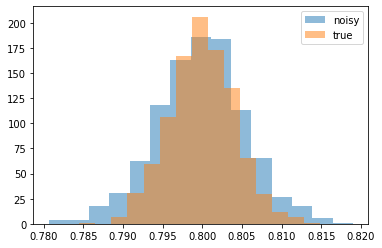

In [17]:
show_hists(0.8, 0.8)

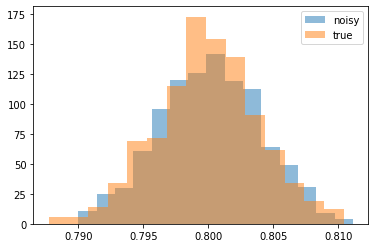

In [18]:
show_hists(0.8, 0.999)

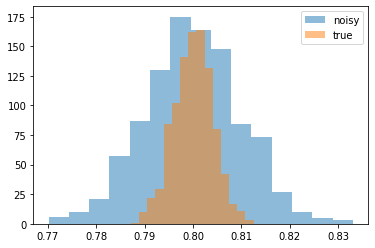

In [19]:
show_hists(0.8, 0.5)

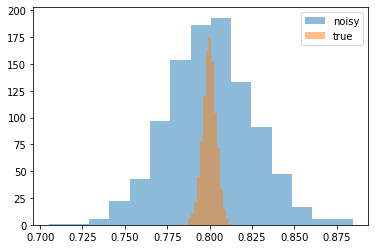

In [20]:
show_hists(0.8, 0.2)

In [21]:
import pandas
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [22]:
df = pandas.read_csv('data/income_data.csv', skipinitialspace=True)

In [23]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0


In [24]:
df['education'].isin(['Masters', 'Bachelors', 'Doctorate', 'Prof-school'])*1

0        1
1        1
2        0
3        0
4        1
        ..
32556    0
32557    0
32558    0
32559    0
32560    0
Name: education, Length: 32561, dtype: int64

In [25]:
higher_ed = ['Masters', 'Bachelors', 'Doctorate', 'Prof-school']

def mk_randomized_pipeline(theta):
    return Pipeline(steps=[
        ('higher-ed', FunctionTransformer(lambda x: x.isin(higher_ed)*1)),
        ('randomize', FunctionTransformer(randomize, kw_args={'theta': theta}))
    ])

def feature_transform(theta):
    return ColumnTransformer(transformers=[
        ('randomize_ed', mk_randomized_pipeline(theta), ['education']),
        ('age, hours', FunctionTransformer(), ['age', 'hours-per-week']) # maybe feature scale for e.g. SVC
    ])

def mk_model(depth, theta):
    return Pipeline(steps=[
        ('feature_transform', feature_transform(theta)),
        ('classifier', DecisionTreeClassifier(max_depth=depth))
    ])

In [26]:
from sklearn import set_config

In [27]:
set_config(display='diagram')

In [28]:
mk_model(3, 0.5).fit(df, df['target'])

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('randomize_ed',
                                                  Pipeline(steps=[('higher-ed',
                                                                   FunctionTransformer(func=<function mk_randomized_pipeline.<locals>.<lambda> at 0x110c3f760>)),
                                                                  ('randomize',
                                                                   FunctionTransformer(func=<function randomize at 0x110a04ca0>,
                                                                                       kw_args={'theta': 0.5}))]),
                                                  ['education']),
                                                 ('age, hours',
                                                  FunctionTransformer(),
                                                  ['age', 'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

In [29]:
cross_val_score(mk_model(3, 0.5), df, df['target'], cv=10)

array([0.76696346, 0.77149877, 0.77457002, 0.77119165, 0.76812039,
       0.77641278, 0.77272727, 0.77334152, 0.77457002, 0.76259214])

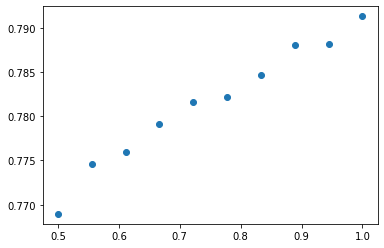

In [30]:
thetas = numpy.linspace(0.5, 1.0, 10)
scores = [cross_val_score(mk_model(3, theta), 
                          df, df['target'], cv=10).mean()
         for theta in thetas]
plt.scatter(thetas, scores)